In [195]:
from typing import Callable
import numpy as np

np.random.seed(42)

# K Médias euclidiano

In [196]:
def euclidian_distances(x: np.ndarray, datapoint: np.ndarray):
    distances = []

    for i in range(x.shape[0]):
        distances.append(((x[i] - datapoint)**2).sum()**0.5)

    return np.array(distances)

def euclidian_distance(x: np.ndarray, datapoint: np.ndarray):
    return ((x - datapoint)**2).sum()**0.5

In [197]:
def loyd_kmeans(x: np.ndarray, k: int, distance: Callable[[np.ndarray, np.ndarray], np.ndarray], max_iter: int = 1000):
    n, d = x.shape
    centers = np.random.uniform(low=x.min(), high=x.max(), size=(k, d))
    labels = np.zeros(n)
    for iter_i in range(max_iter):
        for i in range(n):
            distances = distance(centers, x[i])
            labels[i] = np.argmin(distances)

        old_centers = centers.copy()
        for i in range(k):
            if x[labels == i].shape[0] > 0:
                centers[i] = x[labels == i].mean()

        if np.all(old_centers == centers):
            break

    return centers, labels

In [198]:
def db_index(x: np.ndarray, labels: np.ndarray, centers: np.ndarray, distance: Callable[[np.ndarray, np.ndarray], np.ndarray]):
    k = centers.shape[0]
    n, d = x.shape
    # s is the within cluster scatter
    s = np.zeros(k)
    for i in range(k):
        s[i] = np.mean(distance(x[labels == i], centers[i]))

    # d is the between cluster distance
    d = np.zeros((k, k))
    for i in range(k):
        for j in range(k):
            if i != j:
                d[i, j] = distance(centers[i], centers[j])

    d = np.max(d, axis=1)
    db = np.sum(s / d) / k

    return db

In [199]:
import pandas as pd

df = pd.read_csv('quake.csv')
df

,-5.225999999999999801e+01,2.830000000000000071e+01
0,45.53,150.93
1,41.85,142.78
2,29.19,141.15
3,-21.66,169.81
4,23.09,120.58
...,...,...
2172,51.54,-173.11
2173,-10.16,161.01
2174,27.87,139.51
2175,36.43,140.98


In [200]:
data = df.values
data.shape

(2177, 2)

In [201]:
min_classes = 4
max_classes = 20
centers_list_e = []
labels_list_e = []
dbi_list_e = []

# for i in range(20):
for i in range(min_classes, max_classes+1):
    centers, labels = loyd_kmeans(data, i, euclidian_distances, 100)
    centers_list_e.append(centers)
    labels_list_e.append(labels)
    dbi_list_e.append(db_index(data, labels, centers, euclidian_distance))

In [202]:
dbi_list_e = np.array(dbi_list_e)
centers_list_e = np.array(centers_list_e)
labels_list_e = np.array(labels_list_e)

C:\Users\louis\AppData\Local\Temp\ipykernel_27772\3573673347.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  centers_list_e = np.array(centers_list_e)


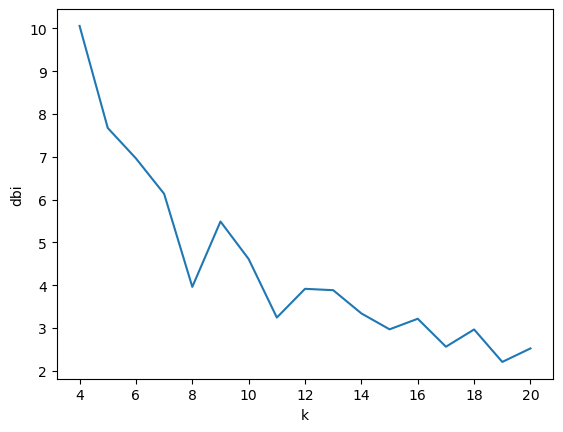

In [203]:
import matplotlib.pyplot as plt

# plotting dbi
plt.plot(np.arange(min_classes, max_classes+1), dbi_list_e)
plt.xlabel('k')
plt.ylabel('dbi')
plt.show()

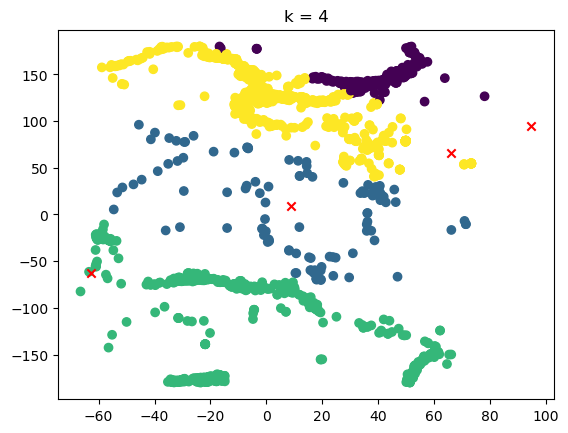

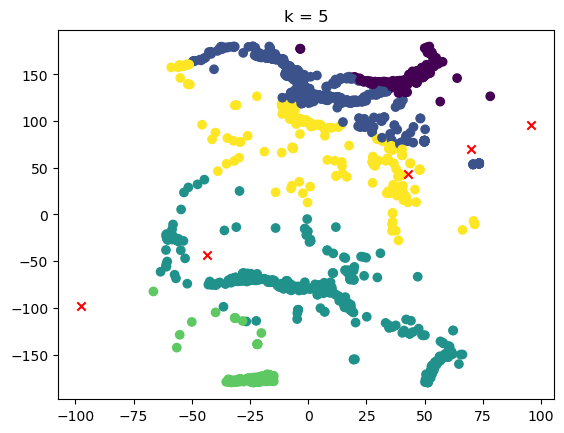

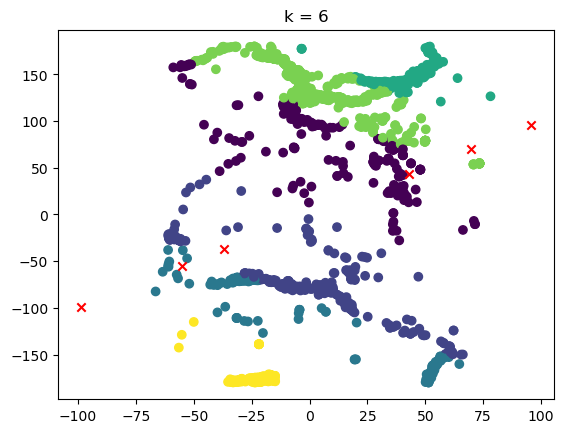

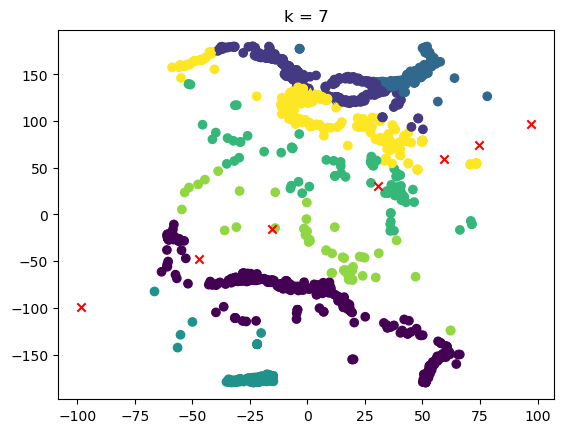

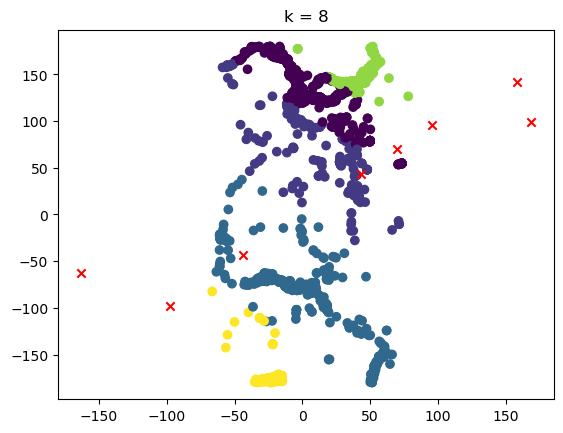

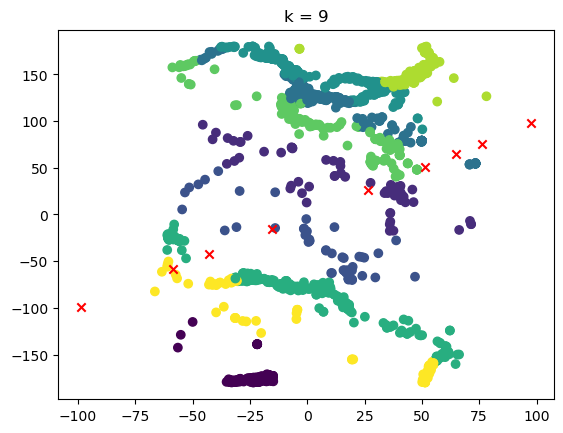

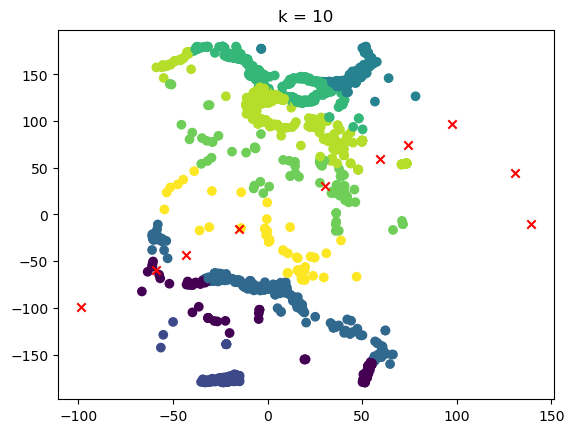

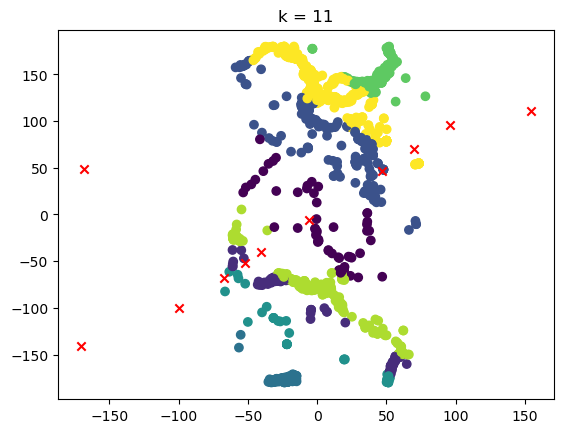

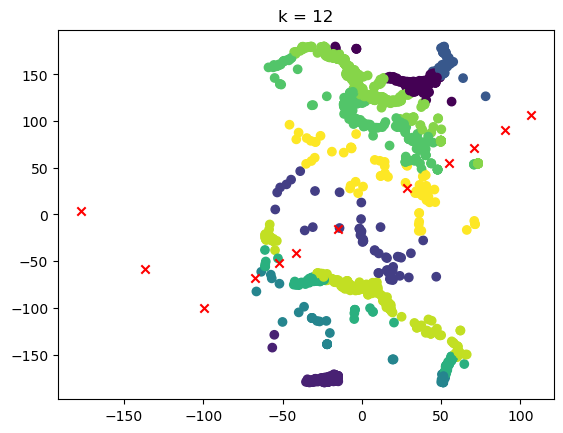

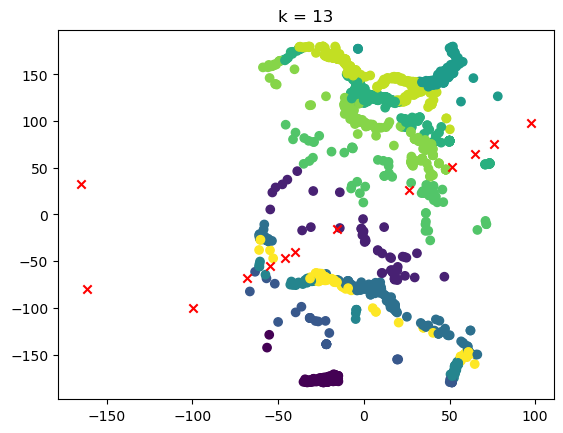

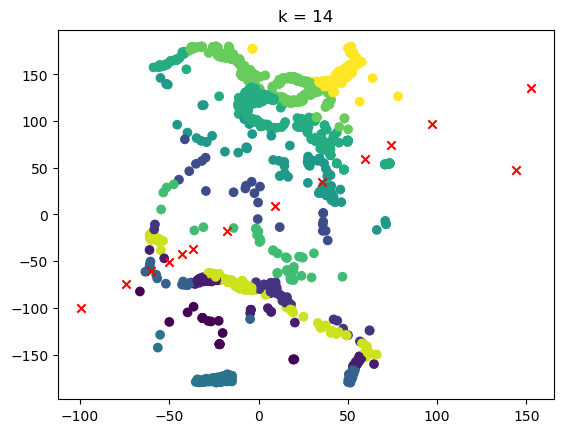

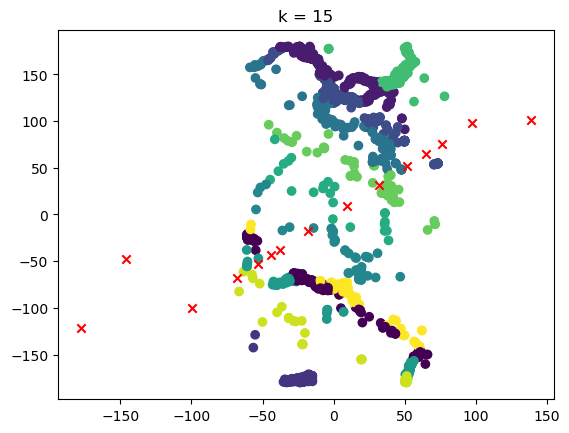

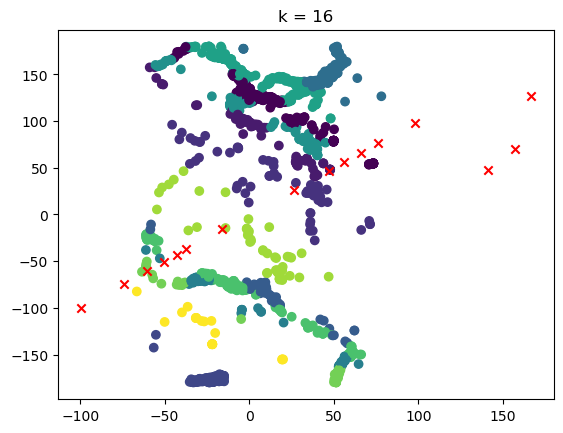

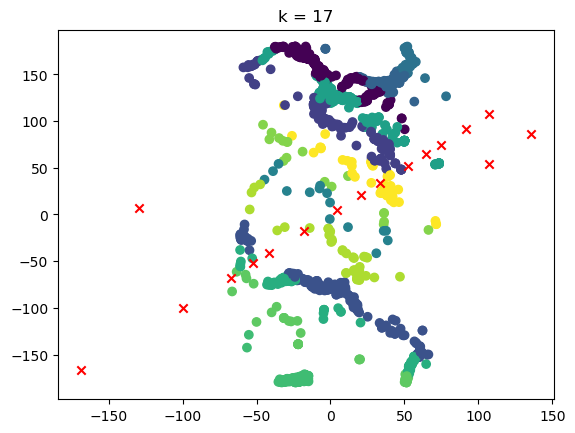

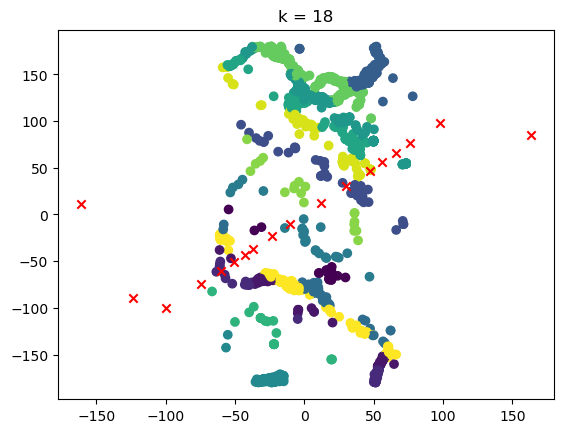

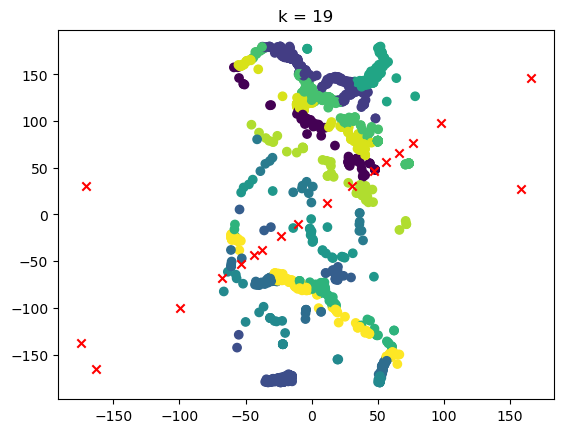

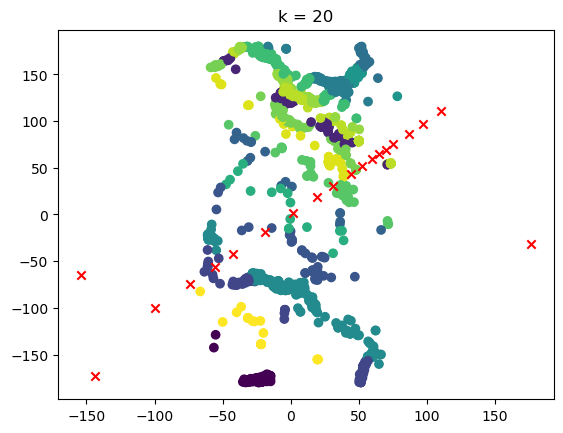

In [204]:
# plotting each cluster
for i in range(centers_list_e.shape[0]):
    plt.scatter(data[:, 0], data[:, 1], c=labels_list_e[i])
    plt.scatter(centers_list_e[i][:, 0], centers_list_e[i][: , 1], c='r', marker='x')
    plt.title(f'k = {i+min_classes}')
    plt.show()

# K Méidas mahalanobis

In [205]:
def mahalanobis_distance(x: np.ndarray, datapoint: np.ndarray, inv_cov: np.ndarray):
    diff = x - datapoint
    distance = np.sqrt(np.dot(np.dot(diff, inv_cov), diff))

    return distance

def mahalanobis_distances(x: np.ndarray, datapoint: np.ndarray, inv_cov: np.ndarray):
    distances = []

    for i in range(x.shape[0]):
        diff = x[i] - datapoint
        distances.append(np.sqrt(np.dot(np.dot(diff, inv_cov), diff)))

    return distances

def cov_inv(x: np.ndarray):
    return np.linalg.inv(np.cov(x))

def cov_pinv(x: np.ndarray):
    return np.linalg.pinv(np.cov(x))

In [206]:
def loyd_kmeans_mah(x: np.ndarray, k: int, distance: Callable[[np.ndarray, np.ndarray, np.ndarray], np.ndarray], max_iter: int = 1000):
    n, d = x.shape
    centers = np.random.uniform(low=x.min(), high=x.max(), size=(k, d))
    labels = np.zeros(n)
    for iter_i in range(max_iter):
        cov_m = cov_inv(x)
        for i in range(n):
            distances = distance(centers, x[i], cov_m)
            labels[i] = np.argmin(distances)

        old_centers = centers.copy()
        for i in range(k):
            if x[labels == i].shape[0] > 0:
                centers[i] = x[labels == i].mean()

        if np.all(old_centers == centers):
            break

    return centers, labels

In [207]:
def db_index_mah(x: np.ndarray, labels: np.ndarray, centers: np.ndarray, distance: Callable[[np.ndarray, np.ndarray, np.ndarray], np.ndarray]):
    k = centers.shape[0]
    n, d = x.shape
    # s is the within cluster scatter
    s = np.zeros(k)
    cov_m = cov_inv(x)
    for i in range(k):
        s[i] = np.mean(distance(x[labels == i], centers[i], cov_m))

    # d is the between cluster distance
    d = np.zeros((k, k))
    for i in range(k):
        for j in range(k):
            if i != j:
                d[i, j] = distance(centers[i], centers[j])

    d = np.max(d, axis=1)
    db = np.sum(s / d) / k

    return db

In [208]:
centers_list_m = []
labels_list_m = []
dbi_list_m = []

# for i in range(20):
for i in range(min_classes, max_classes):
    centers, labels = loyd_kmeans_mah(data, i, mahalanobis_distances, 100)
    centers_list_e.append(centers)
    labels_list_e.append(labels)
    dbi_list_e.append(db_index_mah(data, labels, centers, mahalanobis_distance))

dbi_list_m = np.array(dbi_list_m)
centers_list_m = np.array(centers_list_m)
labels_list_m = np.array(labels_list_m)

ValueError: shapes (2,) and (2177,2177) not aligned: 2 (dim 0) != 2177 (dim 0)

ValueError: x and y must have same first dimension, but have shapes (17,) and (0,)

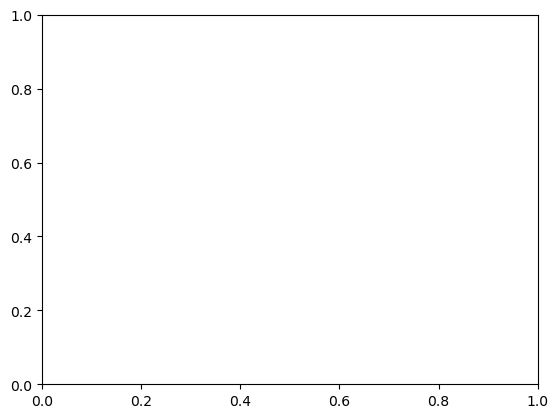

In [209]:
# plotting dbi
plt.plot(np.arange(min_classes, max_classes+1), dbi_list_m)
plt.xlabel('k')
plt.ylabel('dbi')
plt.show()

In [212]:
# plotting each cluster
for i in range(centers_list_m.shape[0]):
    plt.scatter(data[:, 0], data[:, 1], c=labels_list_m[i])
    plt.scatter(centers_list_m[i][:, 0], centers_list_m[i][: , 1], c='r', marker='x')
    plt.title(f'k = {i+min_classes}')
    plt.show()

AttributeError: 'list' object has no attribute 'shape'

# PCA

In [223]:
def principal_component_analysis(x: np.ndarray, dim: int):
    # Translate the dataset so it's centered around 0
    translated_x = x - np.mean(x, axis=0)

    # Calculate the eigenvalues and eigenvectors of the covariance matrix
    e_values, e_vectors = np.linalg.eigh(np.cov(translated_x.T))

    # Sort eigenvalues and their eigenvectors in descending order
    e_ind_order = np.flip(e_values.argsort())
    e_values = e_values[e_ind_order]
    e_vectors = e_vectors[e_ind_order]

    # Save the first n_components eigenvectors as principal components
    principal_components = np.take(e_vectors, np.arange(dim), axis=0)

    return np.matmul(translated_x, principal_components.T)

In [224]:
# clustering using pca
pca = principal_component_analysis(data, 2)
pca

In [225]:
pca = principal_component_analysis(data, 3)
pca

IndexError: index 2 is out of bounds for axis 0 with size 2

In [226]:
pca = principal_component_analysis(data, 4)
pca

IndexError: index 2 is out of bounds for axis 0 with size 2